In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.listdir('data/training/training')

['n6', 'n5', 'n0', 'n7', 'n8', 'n9', 'n1', 'n3', 'n4', 'n2']

In [3]:
train_data_set_path = 'data/training/training'
test_data_set_path =  'data/validation/validation'

In [4]:
training_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [5]:
training_dataset = torchvision.datasets.ImageFolder(root = train_data_set_path, transform = training_transform)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 32, shuffle = False)

In [7]:
#next(iter(train_loader))

In [8]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    Total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        Total_images_count += image_count_in_a_batch
    mean /= Total_images_count
    std  /= Total_images_count

    return mean,std

In [9]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2038]))

In [10]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [11]:
train_dataset = torchvision.datasets.ImageFolder(root = train_data_set_path, transform =train_transforms )
test_dataset = torchvision.datasets.ImageFolder(root = test_data_set_path, transform = test_transforms)

In [12]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6,shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labes:',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labes: tensor([9, 9, 8, 7, 5, 4])


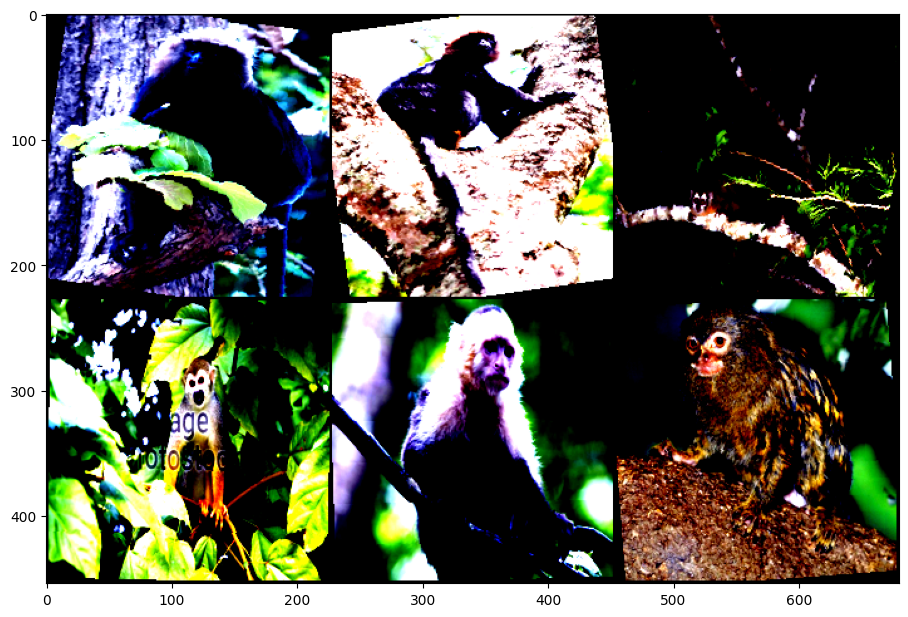

In [13]:
show_transformed_images(train_dataset)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [15]:
def set_device():
    if torch.cuda.is_available():
        #print('cuda gpu is available')
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)     

In [16]:
set_device()

device(type='cuda', index=0)

In [17]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epoch):
    device = set_device()
    best_acc = 0
    for epoch in range(n_epoch):
        print('Epoch number %d' % (epoch +1))
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            
            outputs=model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(" _Training dataset got %d out of %d images correct (%.3f%%).epoch loss:%.3f " % (running_correct, total, epoch_acc, epoch_loss))

        Test_dataset_acc = evaluate_model_on_test_dataset(model, test_loader)
        if(Test_dataset_acc > best_acc):
            best_acc = Test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
        
    print('finished')
    return model

In [18]:
def evaluate_model_on_test_dataset(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0 
    device  = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs=model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted ==labels).sum().item()

    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print(" _Testing dataset. got %d out of %d images correctly(%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))

    return epoch_acc

In [19]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),

    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [20]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained = True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.4MB/s]


In [21]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 30)

Epoch number 1
 _Training dataset got 845 out of 1097 images correct (77.028%).epoch loss:0.668 
 _Testing dataset. got 260 out of 272 images correctly(95.588%)
Epoch number 2
 _Training dataset got 1063 out of 1097 images correct (96.901%).epoch loss:0.093 
 _Testing dataset. got 252 out of 272 images correctly(92.647%)
Epoch number 3
 _Training dataset got 1069 out of 1097 images correct (97.448%).epoch loss:0.095 
 _Testing dataset. got 259 out of 272 images correctly(95.221%)
Epoch number 4
 _Training dataset got 1057 out of 1097 images correct (96.354%).epoch loss:0.106 
 _Testing dataset. got 249 out of 272 images correctly(91.544%)
Epoch number 5
 _Training dataset got 1076 out of 1097 images correct (98.086%).epoch loss:0.054 
 _Testing dataset. got 262 out of 272 images correctly(96.324%)
Epoch number 6
 _Training dataset got 1086 out of 1097 images correct (98.997%).epoch loss:0.030 
 _Testing dataset. got 258 out of 272 images correctly(94.853%)
Epoch number 7
 _Training dat

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
checkpoint =  torch.load('model_best_checkpoint.pth.tar')

In [23]:
print(checkpoint['epoch'])
print(checkpoint['best_acc'])

23
99.26470588235294


In [24]:

resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model']) 

torch.save(resnet18_model, 'best_model.pth')